## Complementary material notebook  

In [1]:
# Library imports
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
import das4whales as dw
import cv2
import gc

In [2]:
# The dataset of this example is constituted of 60s time series along the north and south cables
url = ['http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/'\
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/'\
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5']

selected_channels_m_north = [12000, 66000, 5]  # list of values in meters corresponding to the starting,
                                                # ending and step wanted channels along the FO Cable
                                                # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                                # in meters

In [3]:
# Download some DAS data
url = url[0]
filepath, filename = dw.data_handle.dl_file(url)

# Read HDF5 files and access metadata
# Get the acquisition parameters for the data folder
metadata = dw.data_handle.get_acquisition_parameters(filepath, interrogator='optasense')
fs, dx, nx, ns, gauge_length, scale_factor = metadata["fs"], metadata["dx"], metadata["nx"], metadata["ns"], metadata["GL"], metadata["scale_factor"]

print(f'Sampling frequency: {metadata["fs"]} Hz')
print(f'Channel spacing: {metadata["dx"]} m')
print(f'Gauge length: {metadata["GL"]} m')
print(f'File duration: {metadata["ns"] / metadata["fs"]} s')
print(f'Cable max distance: {metadata["nx"] * metadata["dx"]/1e3:.1f} km')
print(f'Number of channels: {metadata["nx"]}')
print(f'Number of time samples: {metadata["ns"]}')

North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5 already stored locally
Sampling frequency: 200.0 Hz
Channel spacing: 2.0419046878814697 m
Gauge length: 51.0476188659668 m
File duration: 60.0 s
Cable max distance: 66.6 km
Number of channels: 32600
Number of time samples: 12000


In [4]:
selected_channels = dw.data_handle.get_selected_channels(selected_channels_m_north, metadata['dx'])
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filepath, selected_channels, metadata)
cable_name = 'North'

In [5]:
# Create the f-k filter
fk_params = {   # Parameters for the signal
'c_min': 1400.,
'c_max': 3300.,
'fmin': 14.,
'fmax': 30.
}

fk_filter = dw.dsp.hybrid_ninf_gs_filter_design((tr.shape[0],tr.shape[1]), selected_channels, dx, fs, fk_params=fk_params, display_filter=False)

# Apply the f-k filter to the data, returns spatio-temporal strain matrix
trf_fk = dw.dsp.fk_filter_sparsefilt(tr, fk_filter, tapering=True)

# Delete the raw data to free memory
del tr

In [6]:
def gen_Gabor_customcarrier(theta):
    '''
    Generate a Gabor filter with a custom carrier frequency
    '''
    # Parameters 
    print(theta, np.pi/4)
    sigma_mult = 1.2  # Standard deviation of the Gaussian envelope 
    fs = 200  # Sampling frequency
    f_center = 20  # Center frequency
    wavelength = fs / f_center
    sigma = wavelength * sigma_mult
    gamma = 0.5  # Aspect ratio of the Gaussian envelope

    carrier = dw.detect.gen_hyperbolic_chirp(17.8, 28.8, 0.68, fs)
    kernel_size = carrier.shape[0]
    # Create spatial grid
    x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
    y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
    X, Y = np.meshgrid(x, y)
    
    # Rotation matrix
    x_rot = X * np.cos(theta) + Y * np.sin(theta)
    y_rot = -X * np.sin(theta) + Y * np.cos(theta)
    
    # Gabor kernel generation
    spatial_envelope = np.exp(-(x_rot**2 / (2 * (sigma)**2) + 
                                y_rot**2 / (2 * (sigma * gamma)**2)))
    
    carrier = dw.detect.gen_hyperbolic_chirp(17.8, 28.8, 0.68, fs)
    return spatial_envelope * carrier

In [7]:
# Matched filter
HF_note = dw.detect.gen_hyperbolic_chirp(17.8, 28.8, 0.68, fs)
HF_note = np.hanning(len(HF_note)) * HF_note

nmf_m_HF = dw.detect.calc_nmf_correlogram(trf_fk, HF_note)

SNR_hf = dw.dsp.snr_tr_array(nmf_m_HF)

del trf_fk, nmf_m_HF
gc.collect()

100%|██████████| 13223/13223 [00:03<00:00, 3522.17it/s]


1187

Detection speed ratio:  1.8365206
Angle:  61.431355
Gabor filter parameters: theta=2.6429758071899414, lambd=20, sigma=4, ksize=100, gamma=0.15
136


Text(0, 0.5, 'Filter amplitude')

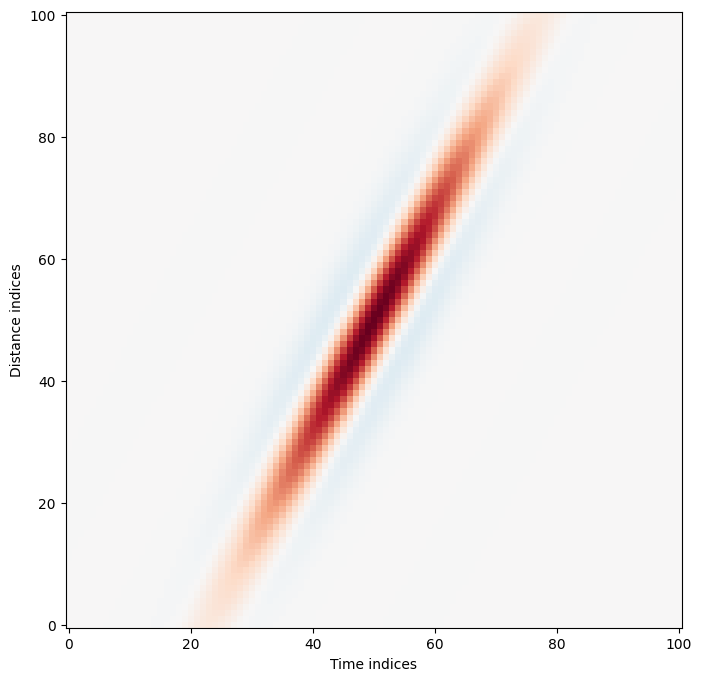

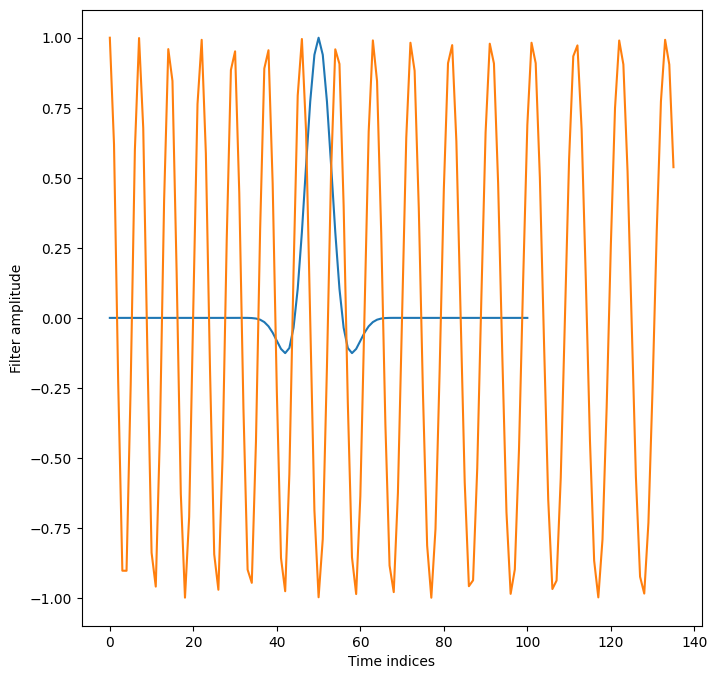

In [8]:
# Create the Gabor filters for envelope clustering
# Detection speed:
c0 = 1500 # m/s
theta_c0 = dw.improcess.angle_fromspeed(c0, fs, dx, selected_channels)

# Define parameters for the Gabor filter
# theta = np.pi/2 + np.deg2rad(theta_c0) # Orientation angle (in radians)
# lambd = 200/20 #theta_c0 * np.pi / 180  # Wavelength of the sinusoidal factor
# sigma = int(lambd * 1) # Standard deviation of the Gaussian envelope
# ksize = 136   # Kernel size 
# gamma = 0.15 # Spatial aspect ratio (controls the ellipticity of the filter)

# lambd = fs / 20 # Wavelength of the sinusoidal carrier
# sigma = 4 # Standard deviation of the Gaussian envelope
# ksize = int(25 * sigma) # Kernel size 
# theta = np.pi/2 + np.deg2rad(theta_c0) # Orientation angle (in radians)
# gamma = 0.15 # Spatial aspect ratio (controls the ellipticity of the filter)

ksize = 100  # Kernel size 
sigma = 4 # Standard deviation of the Gaussian envelope
theta = np.pi/2 + np.deg2rad(theta_c0) # Orientation angle (in radians)
lambd = 20 #theta_c0 * np.pi / 180  # Wavelength of the sinusoidal factor
gamma = 0.15 # Spatial aspect ratio (controls the ellipticity of the filter)

print(f'Gabor filter parameters: theta={theta}, lambd={lambd}, sigma={sigma}, ksize={ksize}, gamma={gamma}')

# Create the Gabor filter
gabor_filtup = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_64F)
gabor_filtdown = np.flipud(gabor_filtup)

# Create custom Gabor filter with hyperbolic carrier
HF_note = dw.detect.gen_hyperbolic_chirp(17.8, 28.8, 0.68, fs)
print(len(HF_note))

plt.figure(figsize=(8, 8))
# plt.subplot(121)
plt.imshow(gabor_filtup, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')
plt.xlabel('Time indices')
plt.ylabel('Distance indices')

# Print one line of the filter (middle line)
plt.figure(figsize=(8, 8))
plt.plot(gabor_filtup[ksize//2, :])
plt.plot(HF_note)
plt.xlabel('Time indices')
plt.ylabel('Filter amplitude')

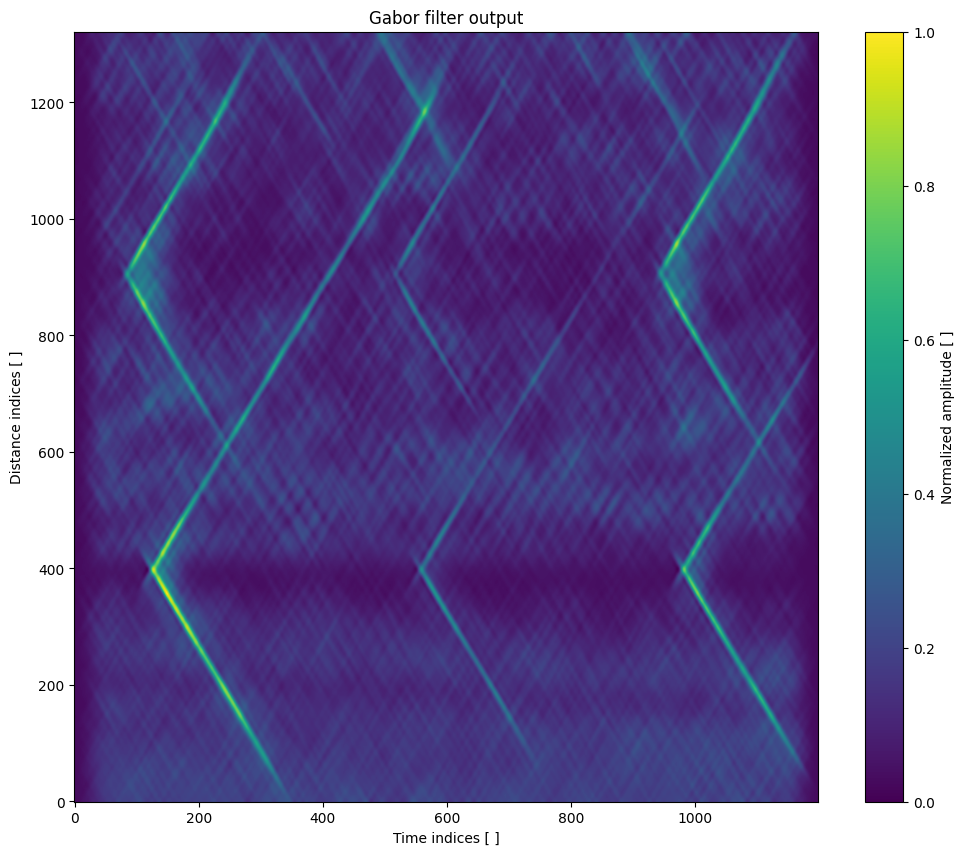

In [14]:
# im = trf_fk.copy()
# im = dw.dsp.snr_tr_array(im)
# im[im < 0] = 0
# imagebin = dw.improcess.binning(im, 1/10, 1/10)
# imagebin = dw.improcess.scale_pixels(imagebin) * 255

# fimage = cv2.filter2D(imagebin,-1, gabor_filtup) + cv2.filter2D(imagebin, -1, gabor_filtdown)
# fimage = abs(sp.hilbert(dw.improcess.scale_pixels(fimage), axis=1))


im = SNR_hf.copy()
im[im < 0] = 0
image = dw.improcess.scale_pixels(im) * 255
imagebin = dw.improcess.binning(image, 1/10, 1/10)

fimage = cv2.filter2D(imagebin, cv2.CV_64F, gabor_filtup) + cv2.filter2D(imagebin, cv2.CV_64F, gabor_filtdown)
fimage = dw.improcess.scale_pixels(fimage)

# Print the image
plt.figure(figsize=(12, 10))
plt.imshow(fimage, cmap='viridis', aspect='auto', origin='lower', vmax=1)
plt.xlabel('Time indices [ ]')
plt.ylabel('Distance indices [ ]')
plt.title('Gabor filter output')
plt.colorbar(label='Normalized amplitude [ ]')

Threshold: 0.38240294973436845


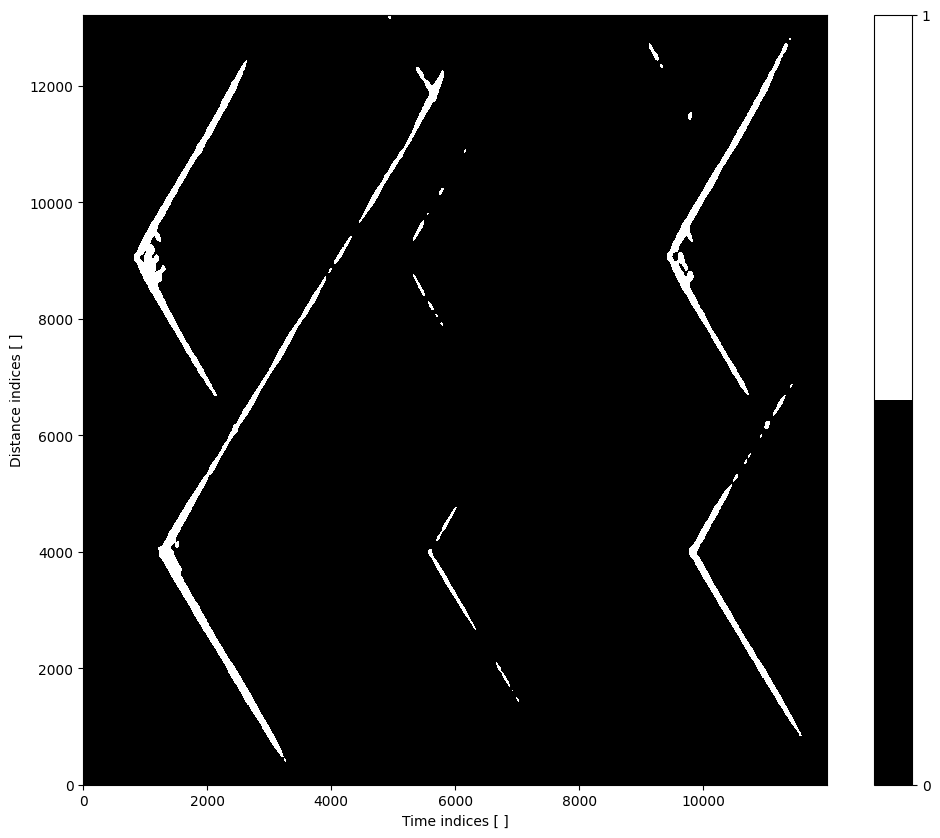

In [21]:
from matplotlib.colors import ListedColormap
# Threshold the image
# threshold = 0.4
threshold = np.mean(fimage) + 3 * np.std(fimage)
print(f'Threshold: {threshold}')
mask = fimage > threshold

mask_sparse = dw.improcess.binning(mask, 10, 10)
# Zero padd the mask to be the same size as the original trace
diff = np.maximum(np.array(im.shape) - np.array(mask_sparse.shape), 0)
mask_sparse_pad = np.pad(mask_sparse, ((0, diff[0]), (0, diff[1])), mode='edge')

plt.figure(figsize=(12, 10))
bin_cmap = ListedColormap(['black', 'white'])
pmask = plt.imshow(mask_sparse_pad, cmap=bin_cmap, aspect='auto', origin='lower')
plt.xlabel('Time indices [ ]')
plt.ylabel('Distance indices [ ]')
plt.colorbar(pmask, ticks=[0, 1])

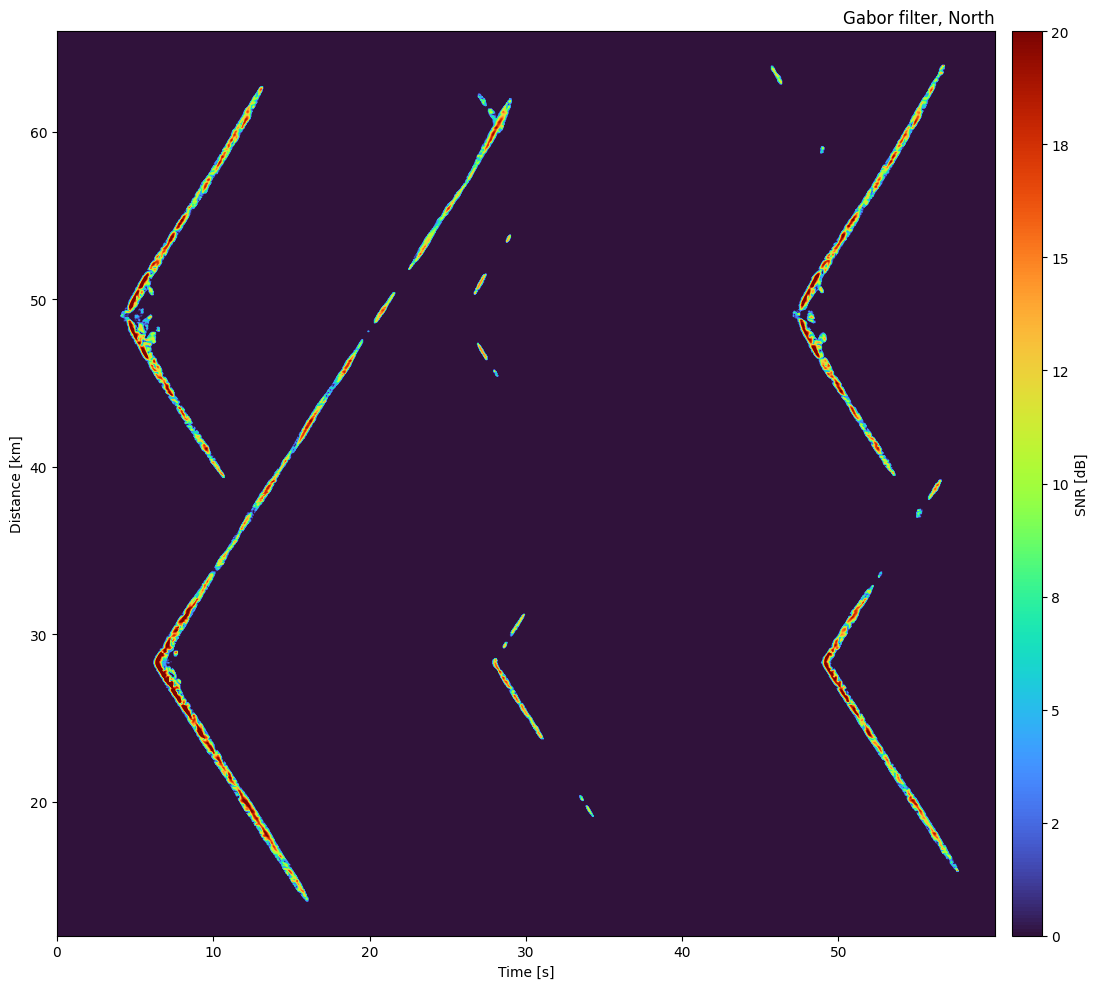

In [11]:

# Apply the mask to the original trace
masked_tr = dw.improcess.apply_smooth_mask(im, mask_sparse_pad)
dw.plot.snr_matrix(masked_tr, time, dist, 20, title_time_info=f"Gabor filter, North")

# plt.figure()
# plt.plot(fimage[380, :])